In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def prepare_data(file_path, train_ratio=0.8):
    # Load and prepare the data
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort by timestamp
    df = df.sort_values('time')
    
    # Get the raw duration values
    durations = df['duration'].values
    
    # Split into train and test
    train_size = int(len(df) * train_ratio)
    train_data = durations[:train_size]
    test_data = durations[train_size:]
    
    return train_data, test_data, df['time'].iloc[train_size:]

def create_prompt(train_data, n_recent_points=50):
    """Create a prompt showing recent historical values and asking for prediction"""
    # Convert the last n points to a readable format
    recent_values = train_data[-n_recent_points:].flatten()
    values_str = ', '.join([f'{val:.3f}' for val in recent_values])
    
    prompt = f"""Given the following time series of function execution durations, predict the next value in the sequence. The recent values are: {values_str}
    
Based on this pattern, what would be the next value? Please respond with only a single numerical value."""
    print(prompt)
    
    return prompt

def get_prediction(model, tokenizer, prompt):
    """Get a single prediction from the model"""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        output = model.generate(
            inputs.input_ids,
            max_new_tokens=20,
            num_return_sequences=1,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Extract the numerical prediction from the response
    try:
        # Find the last number in the response
        import re
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", response)
        if numbers:
            prediction = float(numbers[-1])
        else:
            prediction = None
    except:
        prediction = None
    
    return prediction

def generate_predictions(model, tokenizer, train_data, n_predictions, n_recent_points=100):
    """Generate multiple predictions"""
    predictions = []
    current_sequence = train_data.copy()
    
    for i in range(n_predictions):
        prompt = create_prompt(current_sequence, n_recent_points)
        
        pred = get_prediction(model, tokenizer, prompt)
        
        if pred is not None:
            predictions.append(pred)
            current_sequence = np.append(current_sequence, pred)
        else:
            last_value = current_sequence[-1]
            predictions.append(last_value)
            current_sequence = np.append(current_sequence, last_value)
            
        if (i + 1) % 10 == 0:
            print(f"Generated {i + 1}/{n_predictions} predictions")
    
    return np.array(predictions)

def calculate_metrics(test_data, predictions):
    """Calculate various error metrics"""
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    test_data = test_data[:len(predictions)]
    
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(test_data, predictions)),
        'MAE': mean_absolute_error(test_data, predictions),
        'R2': r2_score(test_data, predictions)
    }
    
    return metrics

def plot_results(train_data, test_data, predictions, test_times):
    """Plot the results"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 6))
    
    train_times = pd.date_range(end=test_times.iloc[0], periods=len(train_data), freq='infer')
    
    plt.plot(train_times, train_data, 
             label='Training Data', color='blue', alpha=0.5)
    
    test_times = test_times[:len(predictions)] 
    plt.plot(test_times, test_data[:len(predictions)], 
             label='Actual Test Data', color='green')
    plt.plot(test_times, predictions, 
             label='LLaMA Predictions', color='red', linestyle='--')
    
    plt.title('Function Duration: LLaMA 2 Predictions')
    plt.xlabel('Time')
    plt.ylabel('Duration')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    model_path = "/engram/naplab/shared/LLaMA2/huggingface/Llama-2-7b-hf"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map='auto',
        torch_dtype="auto",
        low_cpu_mem_usage=True
    )
    
    file_path = "AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled.csv"
    train_data, test_data, test_times = prepare_data(file_path)
    
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    
    n_predictions = len(test_data)  # Predict the same number of points as in test set
    print(f"\nGenerating {n_predictions} predictions...")
    predictions = generate_predictions(model, tokenizer, train_data, n_predictions)
    
    metrics = calculate_metrics(test_data, predictions)
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Plot results
    plot_results(train_data, test_data, predictions, test_times)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]
/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization

Training data shape: (1612,)
Test data shape: (404,)

Generating 404 predictions...
Given the following time series of function execution durations, predict the next value in the sequence. The recent values are: 3.831, 3.606, 3.878, 5.057, 3.879, 4.801, 4.723, 2.425, 1.773, 1.161, 4.398, 0.674, 1.040, 0.964, 1.097, 0.516, 0.252, 0.703, 0.503, 0.856, 0.528, 0.796, 0.796, 0.934, 2.613, 0.888, 1.172, 11.376, 7.388, 10.448, 2.614, 0.832, 2.430, 1.210, 0.718, 0.477, 2.438, 0.266, 0.989, 0.571, 0.626, 0.371, 3.412, 0.472, 0.413, 0.442, 0.490, 0.359, 2.371, 0.970, 0.681, 0.926, 1.205, 0.973, 3.227, 0.534, 0.640, 0.916, 0.606, 0.390, 1.010, 0.468, 0.487, 0.616, 0.446, 0.427, 3.955, 0.518, 0.715, 0.660, 0.989, 0.715, 4.257, 0.440, 1.065, 0.409, 14.472, 7.589, 8.838, 2.893, 4.744, 7.401, 12.795, 17.217, 17.032, 4.817, 2.218, 12.931, 16.066, 19.187, 2.569, 6.212, 9.542, 6.394, 1.702, 0.181, 0.889, 0.299, 0.837, 0.989
    
Based on this pattern, what would be the next value? Please respond with on


KeyboardInterrupt



In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    TrainingArguments, 
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    TaskType
)
from datasets import Dataset
import os
from datetime import datetime

def prepare_training_data(file_path, sequence_length=50, train_ratio=0.8):
    """Prepare the data for fine-tuning"""
    # Load the data
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time')
    
    durations = df['duration'].values
    
    sequences = []
    targets = []
    
    for i in range(len(durations) - sequence_length):
        seq = durations[i:i+sequence_length]
        target = durations[i+sequence_length]
        
        prompt = f"Given the following time series of function execution durations, predict the next value in the sequence. The recent values are: {', '.join([f'{val:.3f}' for val in seq])}\n\nNext value:"
        completion = f" {target:.3f}"
        
        sequences.append(prompt)
        targets.append(completion)
    
    dataset_dict = {
        'text': [prompt + completion for prompt, completion in zip(sequences, targets)]
    }
    
    dataset = Dataset.from_dict(dataset_dict)
    
    train_test = dataset.train_test_split(test_size=1-train_ratio)
    
    return train_test['train'], train_test['test']

def prepare_model_for_training(model_path):
    """Prepare the model for LoRA fine-tuning"""
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map='auto',
    )
    
    lora_config = LoraConfig(
        r=8,  # rank
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )
    
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    
    return model

def train_model(model, train_dataset, val_dataset, tokenizer, output_dir, batch_size=4):
    """Train the model"""
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=4,
        evaluation_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        logging_dir=f"{output_dir}/logs",
        learning_rate=2e-4,
        weight_decay=0.01,
        fp16=True,
        load_best_model_at_end=True,
        warmup_steps=100,
        logging_steps=100,
        optim="adamw_torch"  
    )
    
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            truncation=True,
            max_length=512,
            padding="max_length",
            return_tensors="pt"
        )
    
    train_dataset = train_dataset.map(
        tokenize_function,
        remove_columns=train_dataset.column_names,
        batched=True
    )
    
    val_dataset = val_dataset.map(
        tokenize_function,
        remove_columns=val_dataset.column_names,
        batched=True
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )
    
    trainer.train()
    
    model.save_pretrained(f"{output_dir}/final")
    
    return trainer

def main():
    model_path = "/engram/naplab/shared/LLaMA2/huggingface/Llama-2-7b-hf"
    data_path = "AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled.csv"
    output_dir = f"time_series_llama_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token
    
    print("Preparing datasets...")
    train_dataset, val_dataset = prepare_training_data(data_path)
    
    print("Preparing model for training...")
    model = prepare_model_for_training(model_path)
    
    print("Starting training...")
    trainer = train_model(
        model,
        train_dataset,
        val_dataset,
        tokenizer,
        output_dir
    )
    
    print(f"Training complete. Model saved to {output_dir}")
    
    return model, tokenizer, trainer

if __name__ == "__main__":
    model, tokenizer, trainer = main()

/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-19 23:43:40.169555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 23:43:44.417287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading tokenizer...
Preparing datasets...
Preparing model for training...


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.70s/it]
/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization

Starting training...


Map: 100%|██████████| 394/394 [00:00<00:00, 4133.48 examples/s]
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: siavashshams (naplab_siavash). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


Training complete. Model saved to time_series_llama_20241219_234351


In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_finetuned_model(base_model_path, adapter_path):
    """Load the fine-tuned model with its adapter"""
    print("Loading base model...")
    model = AutoModelForCausalLM.from_pretrained(
        base_model_path,
        torch_dtype=torch.float16,
        device_map='auto'
    )
    
    print("Loading fine-tuned adapter...")
    model = PeftModel.from_pretrained(
        model,
        adapter_path
    )
    
    return model

def prepare_data(file_path, sequence_length=50, train_ratio=0.8):
    """Prepare both train and test data"""
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time')
    
    durations = df['duration'].values
    
    train_size = int(len(df) * train_ratio)
    train_data = durations[:train_size]
    test_data = durations[train_size:]
    test_times = df['time'].iloc[train_size:]
    
    return train_data, test_data, test_times

def create_prediction_prompt(sequence):
    """Create a prompt for prediction"""
    values_str = ', '.join([f'{val:.3f}' for val in sequence])
    prompt = f"""Given the following time series of function execution durations, predict the next value in the sequence. The recent values are: {values_str}

Next value:"""
    return prompt

def get_model_prediction(model, tokenizer, prompt):
    """Get a single prediction from the model"""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        output = model.generate(
            inputs.input_ids,
            max_new_tokens=20,
            num_return_sequences=1,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    
    try:
        import re
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", response)
        if numbers:
            prediction = float(numbers[-1])
        else:
            prediction = None
    except:
        prediction = None
    
    return prediction

def generate_predictions(model, tokenizer, train_data, test_data, sequence_length=50):
    """Generate predictions for full test data using end of training data as initial context"""
    predictions = []
    actual_values = []
    
    current_sequence = train_data[-sequence_length:].copy()
    
    for i in range(len(test_data)):
        prompt = create_prediction_prompt(current_sequence)
        pred = get_model_prediction(model, tokenizer, prompt)
        
        if pred is not None:
            predictions.append(pred)
            actual_values.append(test_data[i])
            
            current_sequence = np.append(current_sequence[1:], test_data[i])
        else:
            last_value = current_sequence[-1]
            predictions.append(last_value)
            actual_values.append(test_data[i])
            current_sequence = np.append(current_sequence[1:], test_data[i])
        
        if (i + 1) % 10 == 0:
            print(f"Generated {i + 1}/{len(test_data)} predictions")
    
    return np.array(predictions), np.array(actual_values)

def calculate_metrics(actual, predictions):
    """Calculate various error metrics"""
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(actual, predictions)),
        'MAE': mean_absolute_error(actual, predictions),
        'R2': r2_score(actual, predictions)
    }
    
    non_zero_mask = actual != 0
    if non_zero_mask.any():
        mape = np.mean(np.abs((actual[non_zero_mask] - predictions[non_zero_mask]) / actual[non_zero_mask])) * 100
        metrics['MAPE'] = mape
    
    return metrics

def plot_predictions(train_data, actual, predictions, test_times):
    """Plot actual vs predicted values including end of training data"""
    plt.figure(figsize=(15, 6))
    
    train_plot_length = 100
    train_times = pd.date_range(end=test_times.iloc[0], periods=train_plot_length, freq='infer')
    plt.plot(train_times, train_data[-train_plot_length:], 
             label='Training Data', color='blue', alpha=0.5)
    
    plt.plot(test_times[:len(actual)], actual, 
             label='Actual Test Data', color='green')
    plt.plot(test_times[:len(predictions)], predictions, 
             label='Predicted', color='red', linestyle='--')
    
    plt.title('Time Series Predictions: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Duration')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

base_model_path = "/engram/naplab/shared/LLaMA2/huggingface/Llama-2-7b-hf"
adapter_path = "/home/ss6928/Cloud/time_series_llama_20241219_234351/final"  
data_path = "AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled.csv"

tokenizer = AutoTokenizer.from_pretrained(base_model_path)
tokenizer.pad_token = tokenizer.eos_token

model = load_finetuned_model(base_model_path, adapter_path)

train_data, test_data, test_times = prepare_data(data_path)

predictions, actual_values = generate_predictions(model, tokenizer, train_data, test_data)

metrics = calculate_metrics(actual_values, predictions)
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

plot_predictions(train_data, actual_values, predictions, test_times)



/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-20 16:41:26.372380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 16:41:28.758842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading tokenizer...
Loading model...
Loading base model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.94s/it]
/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization

Loading fine-tuned adapter...
Preparing data...
Generating predictions...


/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/ss6928/.conda/envs/newenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated 10/404 predictions
Generated 20/404 predictions
Generated 30/404 predictions
Generated 40/404 predictions
Generated 50/404 predictions
Generated 60/404 predictions
Generated 70/404 predictions
Generated 80/404 predictions
Generated 90/404 predictions
Generated 100/404 predictions
Generated 110/404 predictions
Generated 120/404 predictions
Generated 130/404 predictions
Generated 140/404 predictions
Generated 150/404 predictions
Generated 160/404 predictions
Generated 170/404 predictions
Generated 180/404 predictions
Generated 190/404 predictions
Generated 200/404 predictions
Generated 210/404 predictions
Generated 220/404 predictions
Generated 230/404 predictions
Generated 240/404 predictions
Generated 250/404 predictions
Generated 260/404 predictions
Generated 270/404 predictions
Generated 280/404 predictions
Generated 290/404 predictions
Generated 300/404 predictions
Generated 310/404 predictions
Generated 320/404 predictions
Generated 330/404 predictions
Generated 340/404 p

ValueError: Invalid frequency: infer, failed to parse with error message: ValueError("Invalid frequency: INFER, failed to parse with error message: KeyError('INFER')")

<Figure size 1500x600 with 0 Axes>

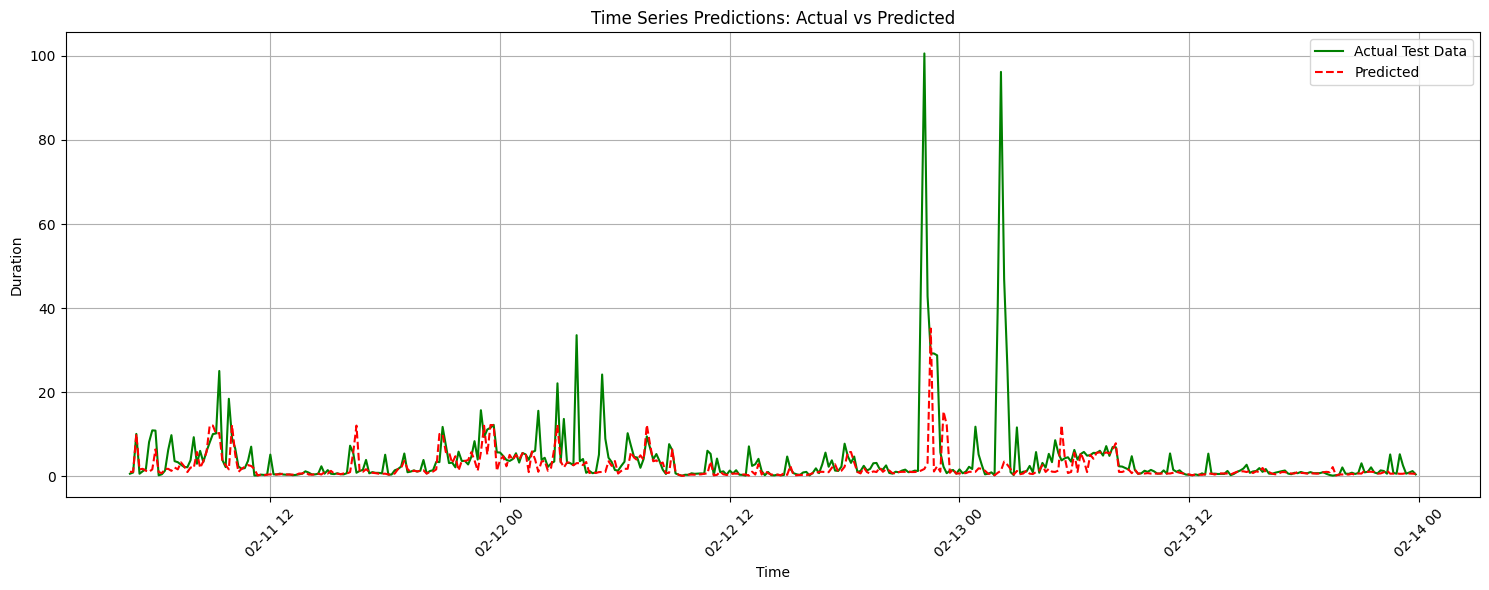

In [19]:


def plot_predictions(actual, predictions, test_times):
    """Plot actual vs predicted values including end of training data"""
    plt.figure(figsize=(15, 6))
    
    time_diff = test_times.iloc[1] - test_times.iloc[0]
    
    train_plot_length = 100
    train_times = [test_times.iloc[0] - time_diff * (train_plot_length - i) for i in range(train_plot_length)]

    plt.plot(test_times[:len(actual)], actual, 
             label='Actual Test Data', color='green')
    plt.plot(test_times[:len(predictions)], predictions, 
             label='Predicted', color='red', linestyle='--')
    
    plt.title('Time Series Predictions: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Duration')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

base_model_path = "/engram/naplab/shared/LLaMA2/huggingface/Llama-2-7b-hf"
adapter_path = "/home/ss6928/Cloud/time_series_llama_20241219_234351/final"  
data_path = "AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled.csv"

train_data, test_data, test_times = prepare_data(data_path)

plot_predictions(actual_values, predictions, test_times)

    

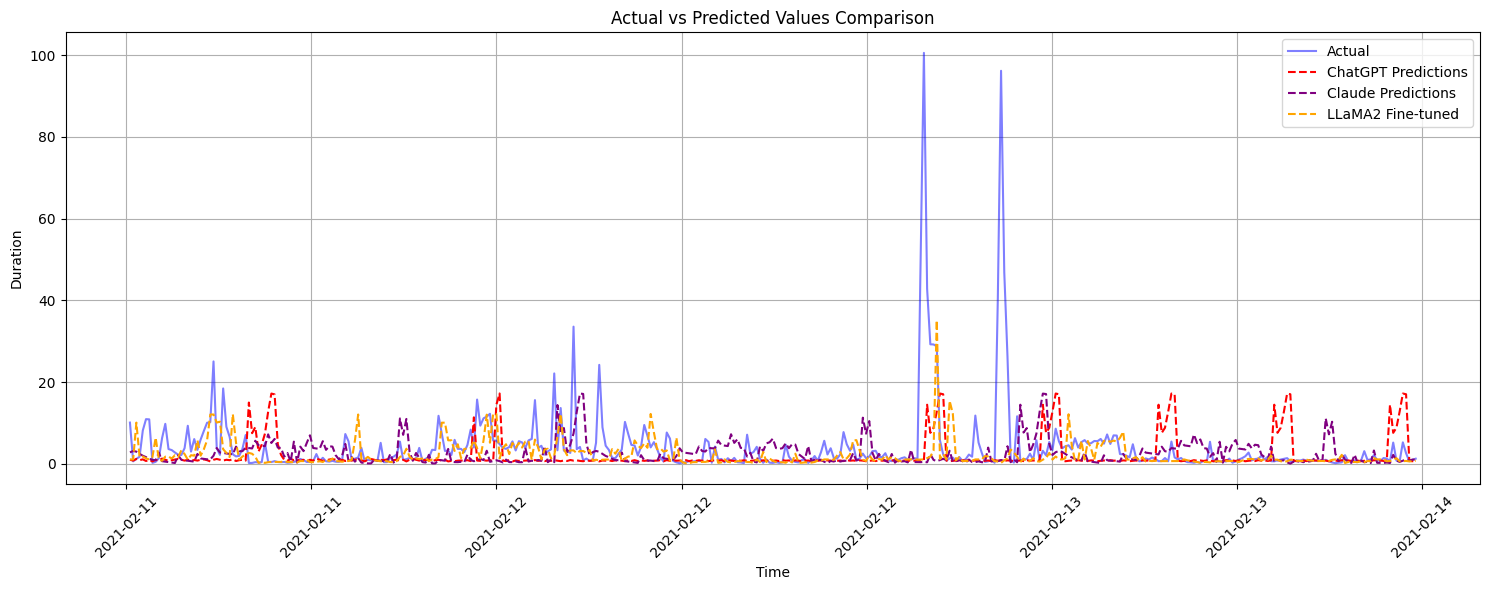

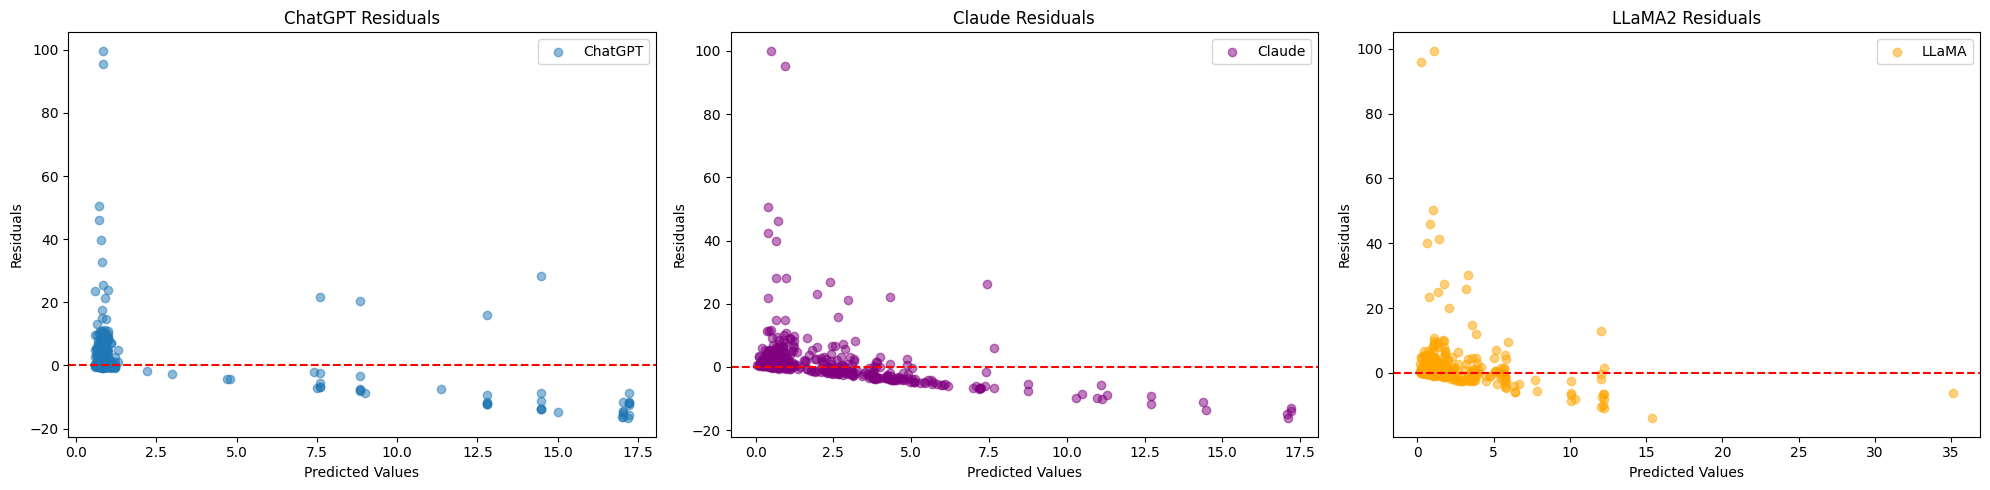


Metrics Comparison:

ChatGPT Metrics:
RMSE: 9.9742
MAE: 4.2689
MAPE: 181.0942
R²: -0.2057
Normalized RMSE: 0.0993
Median Absolute Error: 1.2462
Maximum Error: 99.7170
Within 5 units (%): 76.5586
Within 10 units (%): 88.5287
Within 20 units (%): 96.7581

Claude Metrics:
RMSE: 9.9413
MAE: 4.4899
MAPE: 263.9325
R²: -0.1977
Normalized RMSE: 0.0990
Median Absolute Error: 2.5197
Maximum Error: 100.0671
Within 5 units (%): 76.8080
Within 10 units (%): 92.5187
Within 20 units (%): 96.5087

LLaMA2 Fine-tuned Metrics:
RMSE: 9.3782
MAE: 3.2591
MAPE: 93.9160
R²: -0.0659
Normalized RMSE: 0.0934
Median Absolute Error: 0.8969
Maximum Error: 99.4610
Within 5 units (%): 85.2868
Within 10 units (%): 95.0125
Within 20 units (%): 97.0075


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


def calculate_metrics(y_true, y_pred):
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'R²': r2_score(y_true, y_pred),
        'Normalized RMSE': np.sqrt(mean_squared_error(y_true, y_pred)) / (y_true.max() - y_true.min()),
    }
    
    residuals = y_true - y_pred
    metrics['Median Absolute Error'] = np.median(np.abs(residuals))
    metrics['Maximum Error'] = np.max(np.abs(residuals))
    
    for threshold in [5, 10, 20]:
        within_threshold = np.mean(np.abs(residuals) <= threshold) * 100
        metrics[f'Within {threshold} units (%)'] = within_threshold
    
    return metrics

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    
    df['time'] = pd.to_datetime(df['time'])
    
    df['hour'] = df['time'].dt.hour
    df['day'] = df['time'].dt.dayofweek
    
    for i in range(1, 11):
        df[f'duration_lag{i}'] = df['duration'].shift(i)
    
    df = df.dropna()
    
    return df

def train_test_split(df, train_size=0.8):
    train_size = int(len(df) * train_size)
    
    features = ['hour', 'day'] + [f'duration_lag{i}' for i in range(1, 4)]
    
    X_train = df[features][:train_size]
    y_train = df['duration'][:train_size]
    
    X_test = df[features][train_size:]
    y_test = df['duration'][train_size:]
    
    return X_train, X_test, y_train, y_test



def compare_predictions(chatgpt_csv_path, claude_csv_path, actual_data_path, llama_predictions):
    """Compare predictions from different models"""
    
    chatgpt_df = pd.read_csv(chatgpt_csv_path)
    chatgpt_df['time'] = pd.to_datetime(chatgpt_df['time'])
    chatgpt_predictions = chatgpt_df['duration'].values
    
    claude_df = pd.read_csv(claude_csv_path)
    claude_df['time'] = pd.to_datetime(claude_df['time'])
    claude_predictions = claude_df['duration'].values
    
    df = load_and_prepare_data(actual_data_path)[:-1]
    X_train, X_test, y_train, y_test = train_test_split(df)
    
    chatgpt_metrics = calculate_metrics(y_test, chatgpt_predictions[:len(y_test)])
    claude_metrics = calculate_metrics(y_test, claude_predictions[:len(y_test)])
    llama_metrics = calculate_metrics(y_test, llama_predictions[:len(y_test)])
    
    plt.figure(figsize=(15, 6))
    
    timestamps = df['time'].values[len(X_train):][:len(y_test)]
    
    plt.plot(timestamps, y_test, 
             label='Actual', color='blue', alpha=0.5)
    plt.plot(timestamps, chatgpt_predictions[:len(y_test)], 
             label='ChatGPT Predictions', color='red', linestyle='--')
    plt.plot(timestamps, claude_predictions[:len(y_test)], 
             label='Claude Predictions', color='purple', linestyle='--')
    plt.plot(timestamps, llama_predictions[:len(y_test)], 
             label='LLaMA2 Fine-tuned', color='orange', linestyle='--')

    plt.title('Actual vs Predicted Values Comparison')
    plt.xlabel('Time')
    plt.ylabel('Duration')
    plt.xticks(rotation=45)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(131)
    residuals_chatgpt = y_test - chatgpt_predictions[:len(y_test)]
    plt.scatter(chatgpt_predictions[:len(y_test)], residuals_chatgpt, 
                alpha=0.5, label='ChatGPT')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('ChatGPT Residuals')
    plt.legend()
    
    plt.subplot(132)
    residuals_claude = y_test - claude_predictions[:len(y_test)]
    plt.scatter(claude_predictions[:len(y_test)], residuals_claude, 
                alpha=0.5, label='Claude', color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Claude Residuals')
    plt.legend()
    
    plt.subplot(133)
    residuals_llama = y_test - llama_predictions[:len(y_test)]
    plt.scatter(llama_predictions[:len(y_test)], residuals_llama, 
                alpha=0.5, label='LLaMA', color='orange')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('LLaMA2 Residuals')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nMetrics Comparison:")
    print("\nChatGPT Metrics:")
    for metric, value in chatgpt_metrics.items():
        print(f"{metric}: {value:.4f}")
        
    print("\nClaude Metrics:")
    for metric, value in claude_metrics.items():
        print(f"{metric}: {value:.4f}")
        
    print("\nLLaMA2 Fine-tuned Metrics:")
    for metric, value in llama_metrics.items():
        print(f"{metric}: {value:.4f}")
     
    return chatgpt_metrics, claude_metrics, llama_metrics

# Usage example:
if __name__ == "__main__":
    chatgpt_metrics, claude_metrics, llama_metrics = compare_predictions(
        'AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled_gpto1.csv',  
        'AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled_claude.csv',   
        'AzureFunctionsInvocationTraceForTwoWeeksJan2021_resampled.csv',
        predictions  
    )